## Test a Gyro GP relation in PyStan

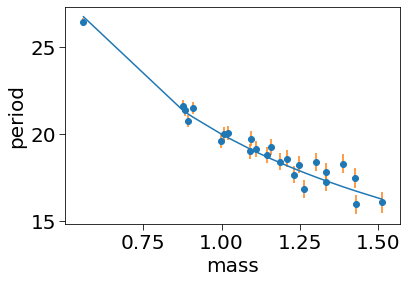

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pystan

npts = 25
mass = np.sort(np.random.randn(npts) * 0.2 + 1.2)

period = 2.0 * 10**1.0 * mass**-0.5
noise = mass * 0.4 * np.random.randn(npts)
sigma = mass * 0.4

fig, ax = plt.subplots()
ax.plot(mass, period)
ax.scatter(mass, period + noise,zorder=1)
ax.errorbar(mass, period+noise, yerr=sigma, fmt='|',zorder=0)
ax.set_xlabel('mass')
ax.set_ylabel('period')
plt.show()

In [21]:
from scipy import stats
slope, intercept, _, _, _ = stats.linregress(mass, period)
slope, intercept


(-9.740955734352607, 30.145960588372382)

In [5]:
gpfit = '''
data {
    int<lower=1> N;
    real M[N];
    vector[N] P;
    real sigma[N];
}
transformed data{
    real delta = 1e-9;
}
parameters {
    real<lower=0> alpha;
    real<lower=0> rho;
    real m0;
    real c0;
    vector[N] eta;
}
transformed parameters{
    vector[N] f;
    {
        vector[N] mu;
        matrix[N, N] L_K;
        matrix[N, N] K = cov_exp_quad(M, alpha, rho);
        
        // diagonal elements
        for (n in 1:N){
            K[n, n] = K[n, n] + delta;
            mu[n] = m0 * M[n] + c0;
        }
        
        L_K = cholesky_decompose(K);
        f = mu + L_K * eta;
    }
}
model {
    rho ~ inv_gamma(5, 5);
    alpha ~ std_normal();
    eta ~ std_normal();
    
    m0 ~ normal(-10, 3);
    c0 ~ normal(25, 10);
    
    P ~ normal(f, sigma);
}
'''
sm = pystan.StanModel(model_code = gpfit, model_name='gpfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL gpfit_3c120451f132e54078c9add38f313c59 NOW.


In [32]:
data = {'N' : len(mass),
       'P' : period+noise,
       'sigma' : np.abs(noise),
       'M' : mass}
init = {'alpha' : 0.4,
        'rho' : 1.,
         'm0' : slope,
         'c0' : intercept}

In [33]:
fit = sm.sampling(data=data, iter=10000, chains=4, seed=11,
                  init = [init for n in range(4)])

In [34]:
print(fit)

Inference for Stan model: gpfit_3c120451f132e54078c9add38f313c59.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     1.76  3.8e-3   0.56   0.84   1.35   1.71    2.1   3.01  21320    1.0
rho        0.6  9.7e-4   0.13   0.39   0.51   0.59   0.67   0.88  16746    1.0
m0       -10.9    0.01   1.61 -14.06 -11.94 -10.92  -9.86  -7.69  15407    1.0
c0       32.98    0.02   2.23  28.62  31.52  32.91  34.39  37.55  14283    1.0
eta[1]   -0.42  6.8e-3   0.91  -2.21  -1.03  -0.42   0.19   1.34  17491    1.0
eta[2]   -1.49  4.4e-3   0.61  -2.78  -1.88  -1.46  -1.07  -0.38  19039    1.0
eta[3]    1.22  4.8e-3   0.76  -0.19   0.69   1.19   1.72   2.77  24896    1.0
eta[4]    0.22  5.1e-3   0.93  -1.59  -0.41   0.22   0.84   2.05  33479    1.0
eta[5]    0.21  5.0e-3   0.96  -1.66  -0.45   0.21   0.85   2.12  36979    1.0
eta[6]    0.12  5.1e-3  

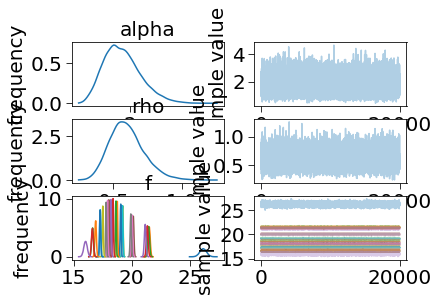

In [35]:
fit.plot(pars=['alpha','rho','f'])
plt.show()

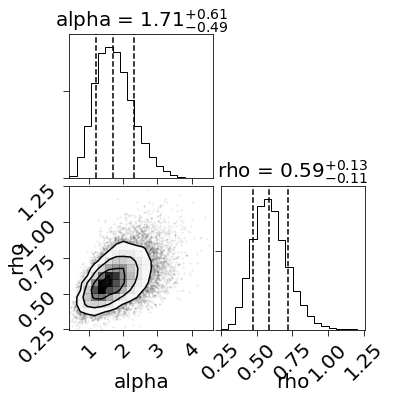

In [36]:
import corner
labels=['alpha','rho']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels,
              quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

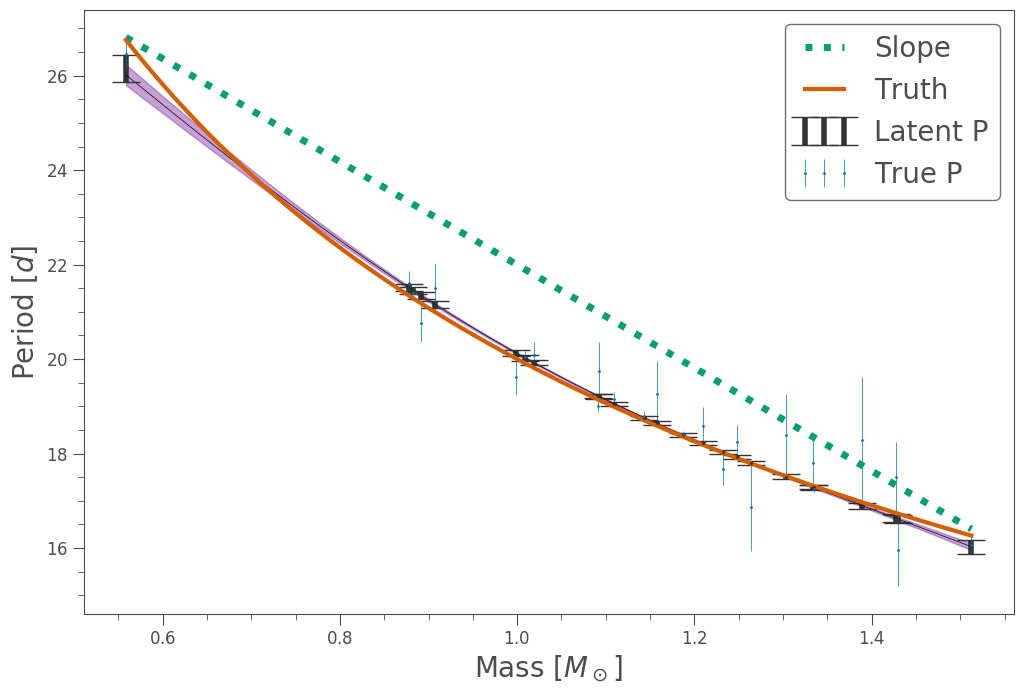

In [41]:
def kernel(x, y, p):
    return p[0]**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / p[1]**2)    

def predict(t_2, t_1, kernel, theta, a, c, y_1, y_v):
    B = kernel(t_1, t_2, theta).T
    A = kernel(t_1, t_1, theta).T + np.diag(y_v)
    C = kernel(t_2, t_2, theta).T
    
    y = c + np.dot(np.dot(B, np.linalg.inv(A)), (y_1 - a))
    Sigma = C - np.dot(np.dot(B, np.linalg.inv(A)),B.T)
            
    y_pred = y 
    sigma_new = np.sqrt(np.diagonal(Sigma))
    return y_pred, sigma_new

Ps = np.median(fit['f'], axis=0)
Ps_std = np.std(fit['f'],axis=0)
# Ps = period
# Ps_std = sigma

alpha = np.median(fit['alpha'])
rho = np.median(fit['rho'])

npts = 500

m0 = np.median(fit['m0'])
c0 = np.median(fit['c0'])

mass2 = np.linspace(np.min(mass), np.max(mass), npts)

a = m0*mass + c0
c = m0*mass2 + c0


theta = [alpha, rho]
Ps_pred, sigmas = predict(mass2, mass, kernel, theta, a, c, Ps, Ps_std**2)

import mystyle

with plt.style.context(mystyle.ms):

    fig, ax = plt.subplots(figsize=(12,8))

    ax.fill_between(mass2, Ps_pred-sigmas, Ps_pred+sigmas, alpha=.5, color='#8d44ad')
    ax.plot(mass2, Ps_pred, c='k')
    ax.errorbar(mass, Ps, yerr=Ps_std, fmt='o', lw=4, capsize=10, label= 'Latent P')
    ax.errorbar(data['M'], data['P'], yerr = data['sigma'], fmt='o',  label='True P')

    plt.plot(mass2, c, lw=5, ls=':', label='Slope')
    
    plt.plot(mass2, 2.0 * 10**1.0 * mass2**-0.5, lw=3, label='Truth')
    
    ax.set_xlabel(r'Mass [$M_\odot$]', fontsize=20)
    ax.set_ylabel(r'Period [$d$]', fontsize=20)
    ax.legend(fontsize=20)
    plt.show()